# Progetto: Predire il tasso di crescita della disocupazione a Barcellona

**Corso di Programmazione di Applicazioni Data Intensive**

##Introduzione

Il progetto consiste nell'analisi di alcuni insiemi di dati relativi alla città di Barcellona per determinare se sia possibile e con quale percentuale di accuratezza predire il futuro tasso di disoccupazione della città tramite l'applicazione di differenti modelli di apprendimento.<br><br>
Per effettuare questa analisi si rendono necessarie una serie di operazioni preliminari che verranno di seguito descritte.<br><br>

### Operazioni preliminari

**1. Caricamento delle librerie**:
   - **NumPy**: per creare e operare su array a N dimensioni;
   - **pandas**: per caricare e manipolare dati tabulari;
   - **sklearn**: per l'addestramento di modelli predittivi. <br>Di questa libreria vengono utilizzati:
       - linear_model;
       - pipeline;
       - preprocessing;
       - linear_model;
       - metrics;
       - model_selection;
       - lasso;
       - ridge;
   - **matplot**: per creare grafici:
     - abilitandone l'inclusione dei grafici in Jupyter;
   - **goglecolab**: per caricare i file csv su Colab;<br><br>
   Note: 
    - tra le librerie importate vi sono anche, commentate, delle librerie per disabilitare alcuni warning, particolarmente tediosi.
     - ogni libreria viene importata utilizzando il rispettivo alias convenzionale;
<br><br>

**2. Caricamento dei dati dal sito**:<br>

      https://www.kaggle.com/xvivancos/barcelona-data-sets ;

**3. Lettura dei dataset**;

In [0]:
import pandas as pd
import numpy as np
import os.path
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Perceptron, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
import io

#Per disabilitare i warning tediosi 
#import warnings 
#warnings.simplefilter(action='ignore', category=FutureWarning)
#import warnings
#from sklearn.exceptions import DataConversionWarning
#warnings.filterwarnings(action='ignore', category=DataConversionWarning)
#np.seterr(divide='ignore')

In [0]:
uploaded = files.upload()
uneployment_data = pd.read_csv(io.BytesIO(uploaded['unemployment.csv']))

Saving unemployment.csv to unemployment.csv


In [0]:
uploaded = files.upload()
births_data = pd.read_csv(io.BytesIO(uploaded['births.csv']))

Saving births.csv to births.csv


In [0]:
uploaded = files.upload()
immigrants_emigrants_by_sex_data = pd.read_csv(io.BytesIO(uploaded['immigrants_emigrants_by_sex.csv']))

Saving immigrants_emigrants_by_sex.csv to immigrants_emigrants_by_sex.csv


## Analisi dei Dati
I dataset scaricati contegono i dati relativi agli anni compresi tra il 2013 e il 2017, essi includono numerose informazioni, non tutte di interesse per l'analisi che si intende effettuare; per questa ragione per ognuno verranno selezionate solo le colonne di interesse.<br>
A continuazione segue la descrizione dei dataset: 
- **birth_reduced**: contiene le informazioni relative alle nascite dei bambini divisi, tra gli altri, per anno, sesso e quartiere; da questo dataset vengono quindi selezionate le colonne 'Year', 'Neighborhood Name' e in seguito essendo i valori suddivisi per genere vengono sommati per ottenere il numero totale di nascite per ogni anno.
- **immigrants_emigrants_by_sex_data**: racchiude i dati riguardanti il numero di immigranti ed emigranti arrivati in città; anche questi ultimi vengono suddivisi per anno, quartiere e sesso.<br> Da questo dataset vengono selezionate le colonne: 'Year', 'Neighborhood Name' ed essendo come in precedenza affermato i valori divisi per genere vengono sommati per otterenere il numero totale degli immigrati in primo luogo e degli emigrati in secondo.
- **uneployment_data**: è il dataset che costudisce i dati che rappresentano il cuore dell'analisi che si intende effettuare: quelli riguardanti la disoccupazione.<br>
Da esso a differenza di quanto fatto in precedenza, vengono creati due dataset distinti il cui scopo verrà di seguito discusso. 
     - Nel primo vengono selezionate le colonne 'Year', 'Neighborhood Name', 'Month' ed essendo che in questo caso oltre che della colonna relativa al genere, bisogna tenere conto anche di quella 'Demand_occupation' i dati vengono sommati per ottenere il numero di disoccupati ogni anno.
     - Nel secondo vengono considerate solo le prime due colonne precedentemente citate e viene quindi fatta una media* dei valori rilevati ogni mese per ottenere quello annuale.



*Demand_occupation* : rappresenta il numero di richieste di lavoro presentate al centro per l'impiego del comune di Barcellona, essa assume due valori possibili: il primo, "Registered unemployed", descrive le domande di lavoro presentate dai disoccupati e il secondo, "unemployment demand", illustra le domande di lavoro presentate dalle persone attualmente impiegate ma che intendono cambiare occupazione.

*Data la mancanza di specifiche nella descrizione del dataset, si assume che tali valori rappresentino nuove richieste effettuate ogni mese.

In [0]:
birth_reduced = births_data.groupby(['Year', 'Neighborhood Name'])["Number"].sum().reset_index()
immigrants_reduced = immigrants_emigrants_by_sex_data.groupby(['Year', 'Neighborhood Name'])["Immigrants"].sum().reset_index()
emigrants_reduced = immigrants_emigrants_by_sex_data.groupby(['Year', 'Neighborhood Name'])["Emigrants"].sum().reset_index()
uneployment_reduced = uneployment_data.groupby(['Year', 'Neighborhood Name', 'Month'])["Number"].sum().reset_index()
uneployment_reduced2 = uneployment_data.groupby(['Year', 'Neighborhood Name'])["Number"].mean().reset_index()

- Essendo i dati campionati relativamente ridotti vengono creati tre dataset con differenti insiemi di variabili sui quali verranno effettuate le operazioni di predizione.
- Per ognuno dei dataset ne vengono salvate due versioni: una senza indice e una dove la colonna 'Year' viene utilizzata a tale scopo.
    - per farlo viene utilizzato il metodo *set_index* senza ulteriori parametri perchè ne venga "automaticamente" fatta una copia con l'indice scelto.

### Modello 1
Il dataset comprende le colonne che indicano il numero di: disoccupati, nascite, immigranti ed emigranti, suddivisi per anno, quartiere e mese.

In [0]:
df_m1 = uneployment_reduced.merge(birth_reduced, how = 'inner', on = ['Year', 'Neighborhood Name'])
df_m1 = df_m1.merge(immigrants_reduced, how = 'inner', on = ['Year', 'Neighborhood Name'])
df_m1 = df_m1.merge(emigrants_reduced, how = 'inner', on = ['Year', 'Neighborhood Name'])

df_m1.rename(columns={"Number_x": "Unemployed"}, inplace = True)
df_m1.rename(columns={"Number_y": "Birth"}, inplace = True)

df_m1_i = df_m1.set_index("Year")

### Modello 2
Il dataset racchiude le colonne che indicano il numero di: nascite, immigranti ed emigranti e la media dei disoccupati, distribuiti per anno e quartiere.

In [0]:
df_m2 = uneployment_reduced2.merge(birth_reduced, how = 'inner', on = ['Year', 'Neighborhood Name'])
df_m2 = df_m2.merge(immigrants_reduced, how = 'inner', on = ['Year', 'Neighborhood Name'])
df_m2 = df_m2.merge(emigrants_reduced, how = 'inner', on = ['Year', 'Neighborhood Name'])

df_m2.rename(columns={"Number_x": "Unemployed"}, inplace = True)
df_m2.rename(columns={"Number_y": "Birth"}, inplace = True)

df_m2_i = df_m2.set_index("Year")

*In questi primi due metodi si rende necessaria un'operazione di ridenominazione delle colonne che nell'operazione di fusione avevano assunto dei nomi poco significativi.

### Modello 3
Il dataset creato contiene i dati suddivisi per anno, quartiere e mese e al contrario dei precedenti comprende cinque colonne che sono relative alla media di disoccupati nei mesi precedenti.

In [0]:
df_m3=uneployment_reduced.copy(deep=False)
for i in range(1, 6):
    df_m3["NumberLag{}".format(i)] = df_m3["Number"].shift(i)
df_m3.dropna(inplace=True)
df_m3_i = df_m3.set_index("Year")

## Analisi delle singole variabili
- In primo luogo vengono analizzate le distribuzioni dei valori delle principali variabili scelte per ciascun dataset. <br>Viene quindi utilizzato il metodo *describe* per ottenere le principali statistiche e i quartili.
- Di seguito vengono mostrate dettagliatamente le distribuzioni attraverso una serie di grafici.

### Percentili

In [0]:
df_m1.describe()

Year   Unemployed        Birth   Immigrants    Emigrants
count  4332.000000  4332.000000  4332.000000  4332.000000  4332.000000
mean   2015.005540  1427.662050   182.565097  1160.850416   712.584488
std       1.416324   942.877866   121.716706   951.593410   495.307906
min    2013.000000    20.000000     2.000000    14.000000     8.000000
25%    2014.000000   716.500000    89.000000   512.000000   363.000000
50%    2015.000000  1310.000000   171.000000   959.000000   654.000000
75%    2016.000000  2031.250000   255.000000  1554.000000  1008.000000
max    2017.000000  5220.000000   502.000000  5400.000000  2534.000000

In [0]:
df_m2.describe()

Year   Unemployed       Birth   Immigrants    Emigrants
count   361.000000   361.000000  361.000000   361.000000   361.000000
mean   2015.005540   500.746480  182.565097  1160.850416   712.584488
std       1.418126   393.150943  121.871571   952.804160   495.938106
min    2013.000000     5.291667    2.000000    14.000000     8.000000
25%    2014.000000   209.062500   89.000000   512.000000   363.000000
50%    2015.000000   419.104167  171.000000   959.000000   654.000000
75%    2016.000000   666.416667  255.000000  1554.000000  1008.000000
max    2017.000000  2326.208333  502.000000  5400.000000  2534.000000

In [0]:
df_m3.describe()

Year       Number  ...   NumberLag4   NumberLag5
count  4435.000000  4435.000000  ...  4435.000000  4435.000000
mean   2015.002255  1430.845772  ...  1430.616685  1430.556257
std       1.413574   966.884285  ...   967.149321   967.218288
min    2013.000000     0.000000  ...     0.000000     0.000000
25%    2014.000000   701.000000  ...   701.000000   701.000000
50%    2015.000000  1309.000000  ...  1309.000000  1309.000000
75%    2016.000000  2050.500000  ...  2050.500000  2050.500000
max    2017.000000  5220.000000  ...  5220.000000  5220.000000

[8 rows x 7 columns]

Quest'ultima tabella poteva essere ignorata, in quanto per come è stato costruito il dataset i valori riportati sono gli stessi per ogni colonna.<br>
Per evitare le inutili ripetizioni, di seguito verranno ignorate le operazioni che porterebbero allo stesso risultato.<br>
Per questa ragione, i grafici di seguito riportati mostreranno la correlazione di due variabili solo per il primo dataset.

### Distribuzione dei dati

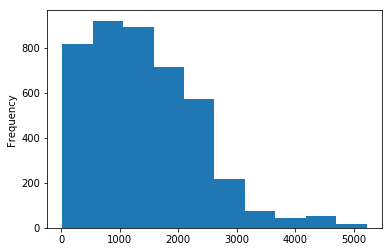

In [0]:
df_m1["Unemployed"].plot.hist()

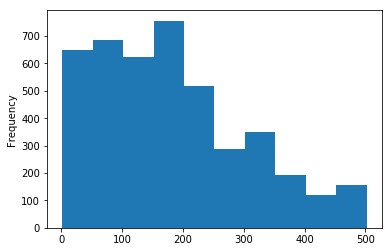

In [0]:
#Distribuzione dei dati
df_m1["Birth"].plot.hist()

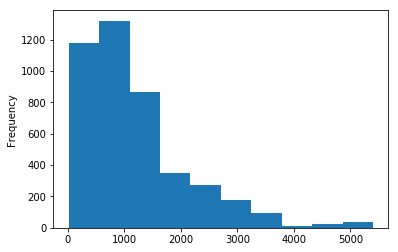

In [0]:
df_m1["Immigrants"].plot.hist()

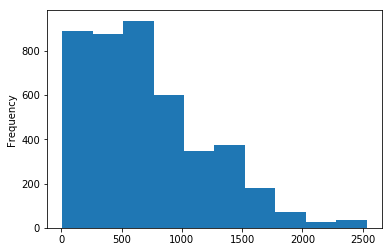

In [0]:
df_m1["Emigrants"].plot.hist()

### Correlazione tra le variabili

Di seguito verrà analizzata la correlazione tra:
- il numero di disoccupati e quello di immigranti;
- il numero di disoccupati e quello delle nascite;
<br>
attraverso alcuni grafici a dispersione.

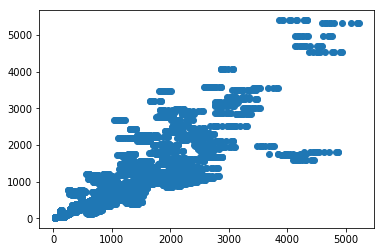

In [0]:
plt.scatter(df_m1.Unemployed, df_m1.Immigrants)

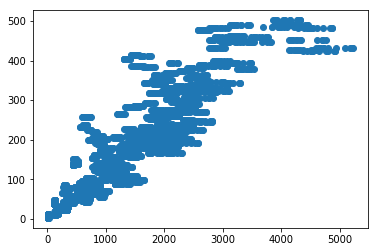

In [0]:
plt.scatter(df_m1.Unemployed, df_m1.Birth)

## Regressione
A continuazione verranno utilizzati diversi modelli di regressione lineare e non per ottenere una stima dei valori di disoccupazione, sulla base di una o più variabili.

## Regressione Lineare 
Con i dati reperiti, viene creato un modello di regressione multivariata per ottenere una stima del numero di disoccupati sulla base di differenti variabili indipendenti.<br>
Il modello viene quindi addestrato su un insieme di m osservazione rappresentate da: 
- una matrice x con m x n valori delle variabili indipendenti;
- un vettore y coi rispettivi m valori noti della variabili dipendente.

Le operazioni principali che verranno effettuate su ogni dataset creato saranno:

- l'estrazione dei dati dai frame per la costruzione della matrice x e del vettore y; 
- l'analisi della correlazione tra il numero di disoccupati e: 
    - il numero di emigranti;
    - il numero di nascite;
    - il numero di emigranti;
- la creazione dei modelli di regressione;

Per comodità verranno usate due funzioni il cui scopo verrà di seguito descritto:
- **relative_error**: verrà utilizzata nella funzione successiva e per questo il suo compito verrà poi discusso;
- **print_eval**: stampa a video tre metriche sui dati forniti:
    - *mean squared error*: stima la differenza quadratica media tra i valori dei dati osservati ed i valori dei dati stimati ;
    - *relative error*: misura di quanto il modello si sbaglia in percentuale rispetto al valore reale;
    - *R-squared coefficient*: determina quanto il modello catturi la variabilità nei dati.

In [0]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))

In [0]:
def print_eval (x, y, model):
    print("Mean squared error:{:.5}".format(mean_squared_error(model.predict(x), y)))
    print("Relative error:{:.5%}".format(relative_error(model.predict(x),y)))
    print("R-squared coefficient:{:.5}".format(model.score(x, y)))

### Modello 1

In [0]:
unemployed = df_m1["Unemployed"].values
birth = df_m1["Birth"].values
immigrants = df_m1["Immigrants"].values
emigrants = df_m1["Emigrants"].values

*values* viene utilizzato per poter estrarre l'array dal frame.

In [0]:
np.mean((unemployed-unemployed.mean()) * (emigrants-emigrants.mean())) / (unemployed.std() * emigrants.std
())

0.9038779652223471

In [0]:
np.mean((unemployed-unemployed.mean()) * (birth-birth.mean())) / (unemployed.std() * birth.std
())

0.8834511272808536

In [0]:
np.mean((unemployed-unemployed.mean()) * (immigrants-immigrants.mean())) / (unemployed.std() * immigrants.std
())

0.8158465179801107

Dai i risulatati ottenuti sembrerebbe che esista una forte correlazione tra le il numero di disoccupati e gli emigranti, così come tra i primi e il numero di nascite.<br>
Al contrario sembrerebbe che la correlazione tra il numero di immigranti non abbia una così forte correlazione col numero di disoccupati.

In [0]:
model_linear=LinearRegression()
x1_linear = df_m1.drop(columns=[ "Month", "Unemployed", "Year", "Neighborhood Name"]).values
y1_linear = df_m1_i["Unemployed"].values
model_linear.fit(x1_linear, y1_linear)
print_eval(x1_linear, y1_linear, model_linear)

Mean squared error:1.3923e+05
Relative error:22.46271%
R-squared coefficient:0.84336


*drop* viene utilizzato per ottenere una copia del frame con le sole colonne selezionate.

### Modello 2

In [0]:
unemployed = df_m2["Unemployed"].values
birth = df_m2["Birth"].values
immigrants = df_m2["Immigrants"].values
emigrants = df_m2["Emigrants"].values

In [0]:
np.mean((unemployed-unemployed.mean()) * (emigrants-emigrants.mean())) / (unemployed.std() * emigrants.std
())

0.7692165159551422

In [0]:
np.mean((unemployed-unemployed.mean()) * (birth-birth.mean())) / (unemployed.std() * birth.std
())

0.7328938172260253

In [0]:
np.mean((unemployed-unemployed.mean()) * (immigrants-immigrants.mean())) / (unemployed.std() * immigrants.std
())

0.6323102010221465

In [0]:
model_linear=LinearRegression()
x2_linear = df_m2.drop(columns=[ "Unemployed", "Year", "Neighborhood Name"]).values
y2_linear = df_m2_i["Unemployed"].values
model_linear.fit(x2_linear, y2_linear)
print_eval(x2_linear, y2_linear, model_linear)

Mean squared error:4.7871e+04
Relative error:38.31142%
R-squared coefficient:0.68943


### Modello 3

In [0]:
model_linear=LinearRegression()
x3_linear = df_m3.drop(columns=[ "Month", "Number", "Year", "Neighborhood Name"]).values
y3_linear = df_m3["Number"].values
model_linear.fit(x3_linear, y3_linear)
print_eval(x3_linear, y3_linear, model_linear)

Mean squared error:1.2462e+05
Relative error:20.71430%
R-squared coefficient:0.86666


**Conclusione**<br>
I risultati ottenuti attraverso la regressione lineare verranno utilizzati come parametri di confronto per gli altri tipi di regressione non lineare e di seguito verrà discusso se questi ultimi possono essere considerati soddisfacenti, o se al contrario non siano particolarmente significativi.
Al momento l'unico tipo di valutazione che può essere fatta è un confronto tra i tre modelli ed appare più che evidente che il terzo modello sembra essere quello più accurato.

## Regressione Polinomiale


### Modello 1

In [0]:
model_linear=LinearRegression()
poly = PolynomialFeatures(degree=3, include_bias=False)
model_linear.fit(poly.fit_transform(x1_linear), y1_linear)
print_eval(poly.transform(x1_linear), y1_linear, model_linear)

Mean squared error:9.0433e+04
Relative error:20.98772%
R-squared coefficient:0.89825


### Modello 2

In [0]:
poly = PolynomialFeatures(degree=3, include_bias=False)
model_linear.fit(poly.fit_transform(x2_linear), y2_linear)
print_eval(poly.transform(x2_linear), y2_linear, model_linear)

Mean squared error:3.2113e+04
Relative error:38.58435%
R-squared coefficient:0.79166


### Modello 3

In [0]:
model_linear=LinearRegression()
poly = PolynomialFeatures(degree=3, include_bias=False)
model_linear.fit(poly.fit_transform(x3_linear), y3_linear)
print_eval(poly.transform(x3_linear), y3_linear, model_linear)

Mean squared error:1.1556e+05
Relative error:20.00656%
R-squared coefficient:0.87636


Operazioni eseguite:
In primo luogo viene utilizzato il filtro *PolynomialFeatures* per aggiungere variabili per la regressione polinomiale; in questo caso vengono scelti: terzo, come grado del polinomio w *include_bias=False*: per escludere la prima colonna in quanto ridondante.
Di seguito viene utilizzato *fit_transform* per far si che il filtro apprenda  la struttura dei dati ed in fine viene addestrato il modello lineare coi dati trasformati.

**Conclusione** <br>
Avendo già i risultati sull'acuratezza della regressione lineare è possibile fare un primo confronto tra quest'ultima e quella polinomiale; da tale comparazione appare decisamente più accurata, per quello che riguarda il primo e il terzo modello, la regressione polinomiale mentre per il terzo modello le due operazioni forniscono dei risultati molto simili.

E' inoltre interessante notare come nel caso della regressione lineare anche con la regressione polinomiale il terzo modello sembra essere quello più accurato. 

## Regressione non lineare: Lasso

Definizione delle variabili che verranno utilizzate per l'addestramento dei modelli.

In [0]:
x1_val= df_m1_i.drop(columns=[ "Month", "Unemployed", "Neighborhood Name"])
y1_val = df_m1_i["Unemployed"]
x1_train, x1_val, y1_train, y1_val= train_test_split(x1_val,y1_val, test_size=1/3, random_state=42)

In [0]:
x2_val= df_m2_i.drop(columns= ["Neighborhood Name", "Unemployed"])
y2_val = df_m2_i["Unemployed"]
x2_train, x2_val, y2_train, y2_val= train_test_split(x2_val,y2_val, test_size=1/3, random_state=42)

In [0]:
x3_val= df_m3_i.drop(columns=[ "Month", "Number", "Neighborhood Name"])
y3_val = df_m3_i["Number"]
x3_train, x3_val, y3_train, y3_val= train_test_split(x3_val,y3_val, test_size=1/3, random_state=42)

La funzione *train_test_split* viene utilizzata per suddividere un set di dati in due insiemi "train" e "test" disgiunti, a tale funzione vengono passati come parametri un dataframe X coi valori delle variabili indipendenti e una serie di y coi valori della variabile dipendente (numero di disoccupati)* da utilizzare per la predizione, la proporzione da inserire nel test piuttosto che nel train.
<br><br>
*le due collezioni di elementi devono avere lo stesso numero di elementi per far sì che siano suddivise insieme applicando a tutte lo stesso ordine casuale dei dati.

Di seguito vengono definiti i due modelli lasso per l'addestramento, i quali differiscono per il peso della regolarizzazione.<br>Per evitare di dover esplicitamente trasformare i dati a ogni iterazione col filtro poly, in questo caso ci si avvale di una pipeline, allo scopo che questa applichi automaticamente i filtri ai dati prima di passarli al modello.<br>Si utilizza inoltre il filtro StandarScaler per eseguire la "standardizzazione" dei dati ed uniformarne quindi i valori.

### Modello 1

In [0]:
model_lasso_1 = Pipeline([
("scale", StandardScaler()),
("linreg", Lasso(alpha=2))
])
model_lasso_1.fit(x1_train, y1_train)
pd.Series(model_lasso_1.named_steps["linreg"].coef_, x1_train.columns)

Birth         237.328839
Immigrants   -290.248636
Emigrants     896.426541
dtype: float64

In [0]:
print_eval(x1_val, y1_val, model_lasso_1)

Mean squared error:1.3833e+05
Relative error:23.19597%
R-squared coefficient:0.84982


### Modello 2

In [0]:
model_lasso_1 = Pipeline([
("scale", StandardScaler()),
("linreg", Lasso(alpha=2))
])
model_lasso_1.fit(x2_train, y2_train)
pd.Series(model_lasso_1.named_steps["linreg"].coef_, x2_train.columns)

Birth          22.882289
Immigrants   -351.223236
Emigrants     621.129112
dtype: float64

In [0]:
print_eval(x2_val, y2_val, model_lasso_1)

Mean squared error:4.2609e+04
Relative error:33.20563%
R-squared coefficient:0.67587


### Modello 3

In [0]:
model_lasso_1 = Pipeline([
("scale", StandardScaler()),
("linreg", Lasso(alpha=2))
])
model_lasso_1.fit(x3_train, y3_train)
pd.Series(model_lasso_1.named_steps["linreg"].coef_, x3_train.columns)

NumberLag1    880.802321
NumberLag2      0.000000
NumberLag3     75.165920
NumberLag4     -0.000000
NumberLag5    -77.481642
dtype: float64

In [0]:
print_eval(x3_val, y3_val, model_lasso_1)

Mean squared error:1.2255e+05
Relative error:20.53069%
R-squared coefficient:0.87239


Cambio il peso della regolarizzazione

### Modello 1

In [0]:
model_lasso_2 = Pipeline([
("scale", StandardScaler()),
("linreg", Lasso(alpha=0.1))
])
model_lasso_2.fit(x1_train, y1_train)
print_eval(x1_val, y1_val, model_lasso_2)

Mean squared error:1.3811e+05
Relative error:23.12675%
R-squared coefficient:0.85005


### Modello 2

In [0]:
model_lasso_2 = Pipeline([
("scale", StandardScaler()),
("linreg", Lasso(alpha=0.1))
])
model_lasso_2.fit(x2_train, y2_train)
print_eval(x2_val, y2_val, model_lasso_2)

Mean squared error:4.2075e+04
Relative error:33.11703%
R-squared coefficient:0.67993


### Modello 3

In [0]:
model_lasso_2 = Pipeline([
("scale", StandardScaler()),
("linreg", Lasso(alpha=0.1))
])
model_lasso_2.fit(x3_train, y3_train)
print_eval(x3_val, y3_val, model_lasso_2)

Mean squared error:1.2244e+05
Relative error:21.14500%
R-squared coefficient:0.87251


**Conclusione**<br>
Il cambiamento nel peso della regolarizzazione applicato alla regressione Lasso non sembra influire in maniera significativa sui risultati ottenuti dal modello.<br>
Inoltre tale regressione non fornisce dei risultati eccezionalmente migliori rispetto ai due tipi di regressioni precedenti, ma è interessante notare come essa confermi il terzo modello come quello più accurato e come riesca ad abbattere il MSE del modello 2 che fino a questo punto non era mai sceso sotto il 38,3%.

## Regressione non lineare: Ridge

### Modello 1

In [0]:
model_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=40, include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", Ridge(alpha=1))
])
model_ridge.fit(x1_train, y1_train)
print_eval(x1_val, y1_val, model_ridge)

Mean squared error:8.0834e+04
Relative error:19.71109%
R-squared coefficient:0.91224


### Modello 2

In [0]:
model_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=20, include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", Ridge(alpha=1))
])
model_ridge.fit(x2_train, y2_train)
print_eval(x2_val, y2_val, model_ridge)

Mean squared error:4.2022e+04
Relative error:32.58252%
R-squared coefficient:0.68033


### Modello 3

In [0]:
model_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=20, include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", Ridge(alpha=1))
])
model_ridge.fit(x3_train, y3_train)
print_eval(x3_val, y3_val, model_ridge)

Mean squared error:3.8576e+05
Relative error:21.03439%
R-squared coefficient:0.59831


**Conclusione**<br>
Con la regressione RIdge si è riusciti a raggiungere quello che sembrerebbe essere il MSE (19.71) minimo e stupisce notare come lo si sia ottenuto con il primo modello e non con il terzo che fino ad ora era sempre risultato come il modello "vincente".<br>
Inoltre questa regressione riesce ad abbassare ulteriormente il MSE del modello 2 portandolo al 32,5%.

## Regressione non lineare: ElasticNet

### Modello 1

In [0]:
model_elastic = Pipeline([
("scale", StandardScaler()),
("linreg", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model_elastic.fit(x1_train, y1_train)
print_eval(x1_val, y1_val, model_elastic)

Mean squared error:1.6335e+05
Relative error:25.98382%
R-squared coefficient:0.82266


### Modello 2

In [0]:
model_elastic = Pipeline([
("scale", StandardScaler()),
("linreg", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model_elastic.fit(x2_train, y2_train)
print_eval(x2_val, y2_val, model_elastic)

Mean squared error:5.7958e+04
Relative error:38.30838%
R-squared coefficient:0.55911


### Modello 3

In [0]:
model_elastic = Pipeline([
("scale", StandardScaler()),
("linreg", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model_elastic.fit(x3_train, y3_train)
print_eval(x3_val, y3_val, model_elastic)

Mean squared error:1.4694e+05
Relative error:23.52652%
R-squared coefficient:0.847


**Conclusione**<br>
I risultati ottenuti con questo tipo di regressione sono significativamente peggiori rispetto a quelli ottenuti con la regressione Ridge e Lasso, nel prossimo paragrafo, si cercherà di migliorarli applicando a questa regressione diversi paramentri ed abbinandola alla GridSearch.

## Regressione non lineare: Grid Search

###  Modello 1

**Regressione Lasso**

In [0]:
model_lasso = Pipeline([
("poly", PolynomialFeatures(include_bias=False)),
("scale", StandardScaler()),
("regr", Lasso( max_iter=20000))
])

grid = {
    "regr__alpha": [0.7, 1],
    "poly__degree": [2, 6], # <- grado polinomio
}

gs_lasso = GridSearchCV(model_lasso, param_grid=grid)
gs_lasso.fit(x1_train, y1_train)
gs_lasso.predict(x1_val.iloc[[0]])
print_eval(x1_val, y1_val, gs_lasso)
gs_lasso.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean squared error:9.6277e+04
Relative error:20.79306%
R-squared coefficient:0.89547


{'poly__degree': 6, 'regr__alpha': 0.7}

**Regressione Ridge**

In [0]:
model_ridge = Pipeline([
("poly", PolynomialFeatures(include_bias=False)),
("scale", StandardScaler()),
("regr", Ridge())
])
grid = {
    "poly__degree": [1, 20], # <- grado polinomio
    "regr__alpha": [ 0.1, 1] # <- regolarizzazione
}
gs_ridge = GridSearchCV(model_ridge, param_grid=grid)

gs_ridge.fit(x1_train, y1_train)
gs_ridge.predict(x1_val.iloc[[0]])
print_eval(x1_val, y1_val, gs_ridge)
gs_ridge.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean squared error:7.7105e+04
Relative error:20.55061%
R-squared coefficient:0.91629


{'poly__degree': 20, 'regr__alpha': 0.1}

**Regressione ElasticNet**

In [0]:
model_elastic = ElasticNet()
grid = {
    "alpha": [10, 1000, 2000],
    "l1_ratio": [0.1, 0.3]
}
gs_elastic = GridSearchCV(model_elastic, param_grid=grid)

gs_elastic.fit(x1_train, y1_train)
gs_elastic.predict(x1_val.iloc[[0]])
print_eval(x1_val, y1_val, gs_elastic)
gs_elastic.best_params_

Mean squared error:1.3811e+05
Relative error:23.12408%
R-squared coefficient:0.85005


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 10, 'l1_ratio': 0.1}

### Modello 2

**Regressione Lasso**

In [0]:
model_lasso = Pipeline([
("poly", PolynomialFeatures(include_bias=False)),
("scale", StandardScaler()),
("regr", Lasso( max_iter=20000))
])

grid = {
    "regr__alpha": [0.5, 1],
    "poly__degree": [2, 6], # <- grado polinomio
}

gs_lasso = GridSearchCV(model_lasso, param_grid=grid)
gs_lasso.fit(x2_train, y2_train)
gs_lasso.predict(x2_val.iloc[[0]])
print_eval(x2_val, y2_val, gs_lasso)
gs_lasso.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean squared error:3.7574e+04
Relative error:32.11814%
R-squared coefficient:0.71417


{'poly__degree': 2, 'regr__alpha': 1}

**Regressione Ridge**

In [0]:
model_ridge = Pipeline([
("poly", PolynomialFeatures(include_bias=False)),
("scale", StandardScaler()),
("regr", Ridge())
])
grid = {
    "poly__degree": [1, 20], # <- grado polinomio
    "regr__alpha": [ 0.1, 1] # <- regolarizzazione
}

gs_ridge = GridSearchCV(model_ridge, param_grid=grid)
gs_ridge.fit(x2_train, y2_train)
gs_ridge.predict(x2_val.iloc[[0]])
print_eval(x2_val, y2_val, gs_ridge)
gs_ridge.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean squared error:4.3255e+04
Relative error:33.29752%
R-squared coefficient:0.67095


{'poly__degree': 1, 'regr__alpha': 1}

**Regressione ElasticNet**

In [0]:
model_elastic = ElasticNet()
grid = {
    "alpha": [10, 1000, 2000],
    "l1_ratio": [0.1, 0.3]
}
gs_elastic = GridSearchCV(model_elastic, param_grid=grid)

gs_elastic.fit(x2_train, y2_train)
gs_elastic.predict(x2_val.iloc[[0]])
print_eval(x2_val, y2_val, gs_elastic)
gs_elastic.best_params_

Mean squared error:4.281e+04
Relative error:33.44703%
R-squared coefficient:0.67434


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 2000, 'l1_ratio': 0.1}

### Modello 3

**Regressione Lasso**

In [0]:
model_lasso = Pipeline([
("poly", PolynomialFeatures(include_bias=False)),
("scale", StandardScaler()),
("regr", Lasso( max_iter=20000))
])

grid = {
    "regr__alpha": [0.5, 1],
    "poly__degree": [2, 6], # <- grado polinomio
}

gs_lasso = GridSearchCV(model_lasso, param_grid=grid)
gs_lasso.fit(x3_train, y3_train)
gs_lasso.predict(x3_val.iloc[[0]])
print_eval(x3_val, y3_val, gs_lasso)
gs_lasso.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean squared error:1.1826e+05
Relative error:20.14408%
R-squared coefficient:0.87686


{'poly__degree': 6, 'regr__alpha': 0.5}

**Regressione Ridge**

In [0]:
model_ridge = Pipeline([
("poly", PolynomialFeatures(include_bias=False)),
("scale", StandardScaler()),
("regr", Ridge())
])
grid = {
    "poly__degree": [1, 20], # <- grado polinomio
    "regr__alpha": [ 0.1, 1] # <- regolarizzazione
}
gs_ridge = GridSearchCV(model_ridge, param_grid=grid)

gs_ridge.fit(x3_train, y3_train)
gs_ridge.predict(x3_val.iloc[[0]])
print_eval(x3_val, y3_val, gs_ridge)
gs_ridge.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean squared error:1.2245e+05
Relative error:21.23598%
R-squared coefficient:0.8725


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'poly__degree': 1, 'regr__alpha': 1}

**Regressione ElasticNet**

In [0]:
model_elastic = ElasticNet()
grid = {
    "alpha": [10, 1000, 2000],
    "l1_ratio": [0.1, 0.3]
}
gs_elastic = GridSearchCV(model_elastic, param_grid=grid)

gs_elastic.fit(x3_train, y3_train)
gs_elastic.predict(x3_val.iloc[[0]])
print_eval(x3_val, y3_val, gs_elastic)
gs_elastic.best_params_

Mean squared error:1.2245e+05
Relative error:20.96222%
R-squared coefficient:0.87249


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 1000, 'l1_ratio': 0.3}

**Conclusione**<br>
L'applicazione della GridSearch alle diverse regressione non provoca miglioramenti, o peggioramenti particolarmente significativi: in particolare nella regressione Lasso si ottengono generalmente dei lievi miglioramenti, nella Ridge dei deboli peggioramenti e nella ElasticNet degli incrementi nella precisione del primo e del terzo modello e un calo nel secondo.<br><br>
**Note**<br>
Per evitare eccessivi ritardi nel tempo di esecuzione del codice, dopo aver testato diversi parametri per i tre modelli sono stati lasciati quelli che portavano i risultati migliori.

## Conclusione finale
Nonostante i tre tipi di modelli testati e le diverse regressioni che ad essi sono state applicate non si è riusciti a migliorare i risultati ottenuti dalla regressione Ridge applicata al primo modello, questa mancanza è probabilmente dovuta alla scarsità dei dati a disposizione.<br>
Tuttavia è comunque possibile designare delle conclusioni generali dai dati raccolti: difatti è più che evidente notare  come il primo e il terzo modello risultano essere sempre quelli più accurati qualsiasi tipo di regressione vi si applichi; ciò è dovuto all'approssimazione che si era dovuta fare riguardante la costruzione del dataset usato secondo modello.